# Using Neural Network classifiers with TPOT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams['figure.figsize'] = (14, 7)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [2]:
data = load_breast_cancer()
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [3]:
features = data.data
target = data.target

df = pd.DataFrame(data=features, columns=data.feature_names)
df['target'] = target
df.sample(8)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
178,13.010,22.22,82.01,526.4,0.06251,0.01938,0.001595,0.001852,0.1395,0.05234,...,29.02,88.18,608.8,0.08125,0.03432,0.007977,0.009259,0.2295,0.05843,1
410,11.360,17.57,72.49,399.8,0.08858,0.05313,0.027830,0.021000,0.1601,0.05913,...,36.32,85.07,521.3,0.14530,0.16220,0.181100,0.086980,0.2973,0.07745,1
246,13.200,17.43,84.13,541.6,0.07215,0.04524,0.043360,0.011050,0.1487,0.05635,...,27.82,88.28,602.0,0.11010,0.15080,0.229800,0.049700,0.2767,0.07198,1
69,12.780,16.49,81.37,502.5,0.09831,0.05234,0.036530,0.028640,0.1590,0.05653,...,19.76,85.67,554.9,0.12960,0.07061,0.103900,0.058820,0.2383,0.06410,1
103,9.876,19.40,63.95,298.3,0.10050,0.09697,0.061540,0.030290,0.1945,0.06322,...,26.83,72.22,361.2,0.15590,0.23020,0.264400,0.097490,0.2622,0.08490,1
453,14.530,13.98,93.86,644.2,0.10990,0.09242,0.068950,0.064950,0.1650,0.06121,...,16.93,103.10,749.9,0.13470,0.14780,0.137300,0.106900,0.2606,0.07810,1
197,18.080,21.84,117.40,1024.0,0.07371,0.08642,0.110300,0.057780,0.1770,0.05340,...,24.70,129.10,1228.0,0.08822,0.19630,0.253500,0.091810,0.2369,0.06558,0
543,13.210,28.06,84.88,538.4,0.08671,0.06877,0.029870,0.032750,0.1628,0.05781,...,37.17,92.48,629.6,0.10720,0.13810,0.106200,0.079580,0.2473,0.06443,1


<br>

## Exploratory Data Analysis

In [4]:
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [5]:
def make_count_chart(column, title, ylabel, xlabel, y_offset=0.12, x_offset=700):
    ax = df[column].value_counts().plot(kind='bar', fontsize=13, color='#4f4f4f')
    ax.set_title(title, size=20, pad=30)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
                  
    for i in ax.patches:
        ax.text(i.get_x() + x_offset, i.get_height() + y_offset, f'{str(round(i.get_height(), 2))}', fontsize=15)
    return ax

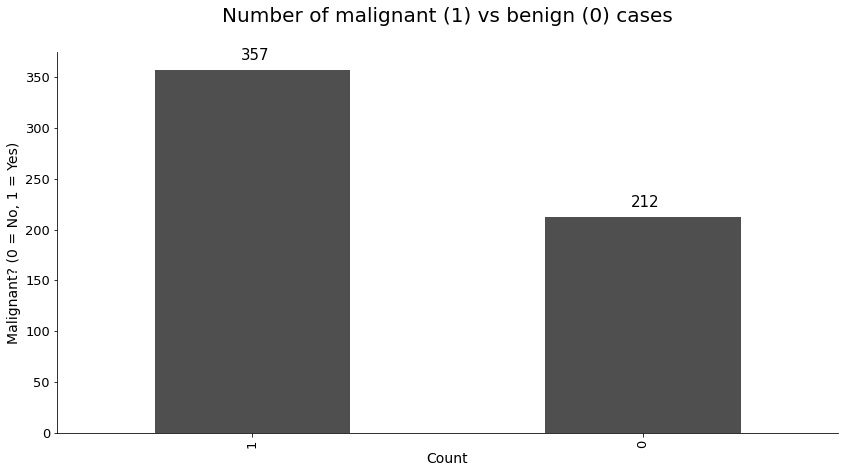

In [6]:
make_count_chart(
    column='target',
    title='Number of malignant (1) vs benign (0) cases',
    ylabel='Malignant? (0 = No, 1 = Yes)',
    xlabel='Count',
    y_offset=10,
    x_offset=0.22
);

In [7]:
np.corrcoef(df['mean area'], df['target'])[1][0]

-0.7089838365853899

In [8]:
corr_with_target = []

for col in df.columns[:-1]:
    corr = np.corrcoef(df[col], df['target'])[1][0]
    corr_with_target.append({'Column': col, 'Correlation': corr})
    
corr_df = pd.DataFrame(corr_with_target)
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

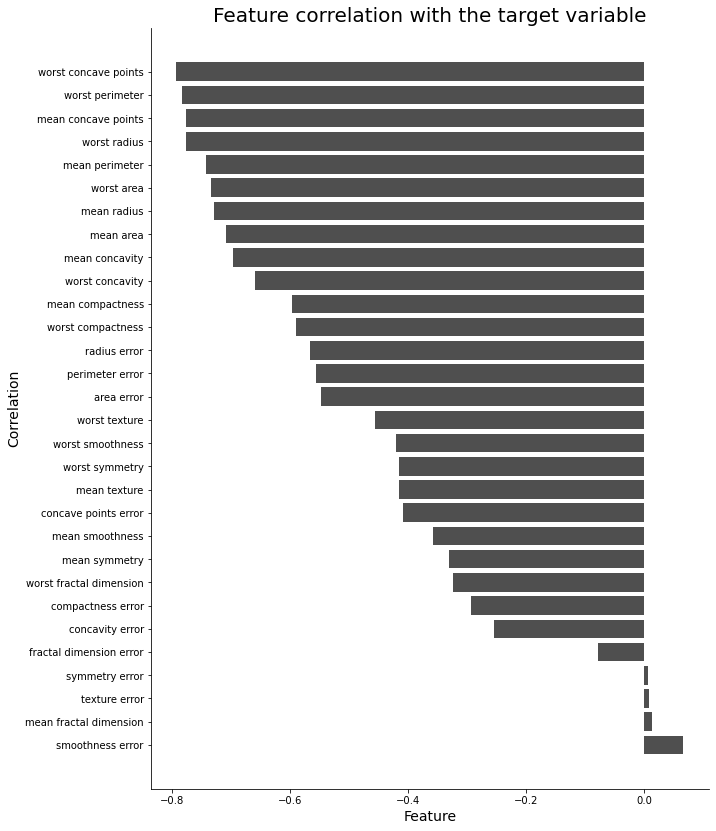

In [9]:
plt.figure(figsize=(10, 14))
plt.barh(corr_df['Column'], corr_df['Correlation'], color='#4f4f4f')
plt.title('Feature correlation with the target variable', fontsize=20)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.show()

In [11]:
def draw_histogram(data, columns, n_rows, n_cols):
    fig = plt.figure(figsize=(12, 18))
    for i, var_name in enumerate(columns):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        sns.histplot(data=data, x=var_name, hue='target')
        ax.set_title(f'Distribution of {var_name}')
    fig.tight_layout()
    plt.show()

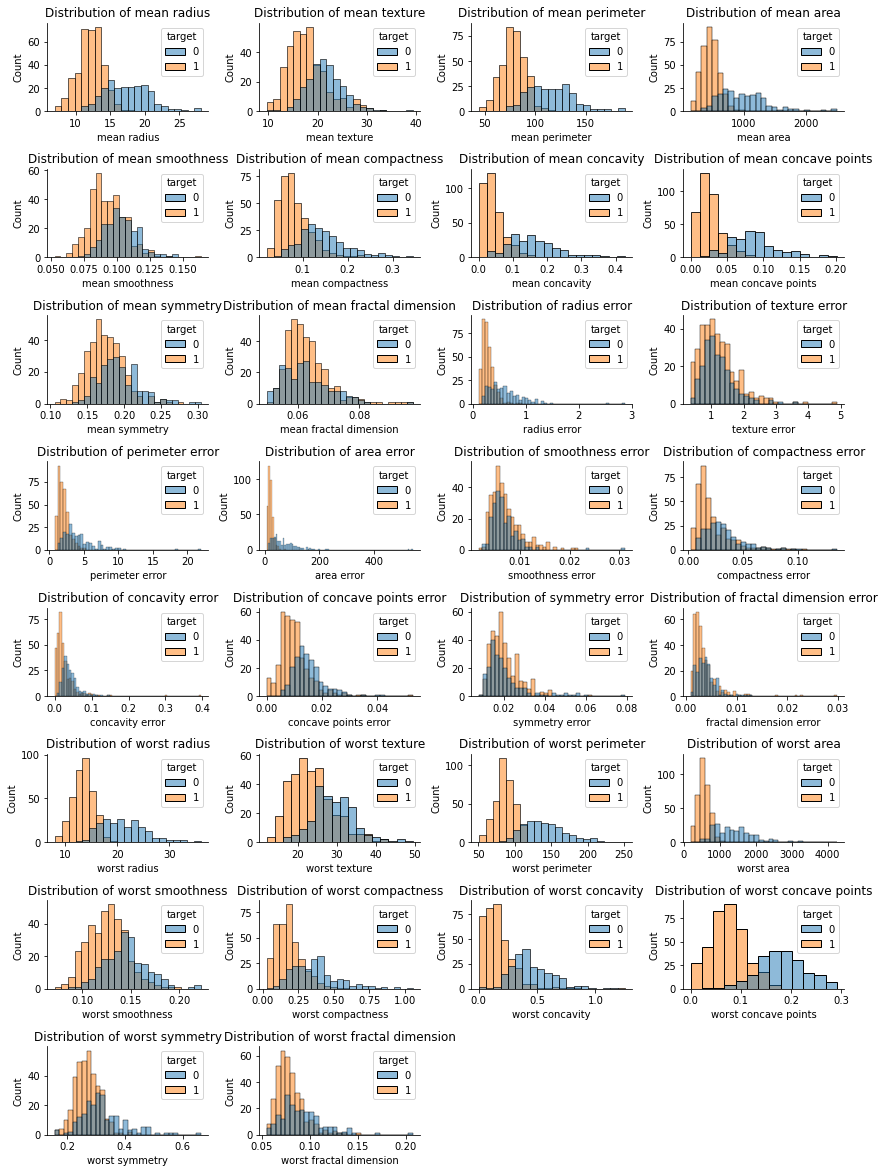

In [12]:
draw_histogram(df, df.columns[:-1], 9, 4)

<br>

## Train/Test Split

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

<br>

## Baseline Model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)

print(confusion_matrix(y_test, lr_preds))
print()
print(accuracy_score(y_test, lr_preds))

[[50  4]
 [ 1 88]]

0.965034965034965


<br>

## Neural Network Logistic Regression Classifier

In [7]:
from tpot import TPOTClassifier

classifier_lr = TPOTClassifier(
    config_dict='TPOT NN',
    template='PytorchLRClassifier',
    generations=2,
    random_state=42,
    verbosity=3
)

In [16]:
classifier_lr.fit(X_train, y_train)

34 operators have been imported by TPOT.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.9153214774281807	PytorchLRClassifier(input_matrix, PytorchLRClassifier__batch_size=32, PytorchLRClassifier__learning_rate=0.5, PytorchLRClassifier__num_epochs=15, PytorchLRClassifier__weight_decay=0.0001)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the op

TPOTClassifier(config_dict='TPOT NN', crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=2,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=42, scoring=None, subsample=1.0,
               template='PytorchLRClassifier', use_dask=False, verbosity=3,
               warm_start=False)

In [18]:
classifier_lr.fitted_pipeline_

Pipeline(memory=None,
         steps=[('pytorchlrclassifier',
                 PytorchLRClassifier(batch_size=32, learning_rate=0.5,
                                     num_epochs=15, verbose=False,
                                     weight_decay=0.0001))],
         verbose=False)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score

tpot_lr_preds = classifier_lr.predict(X_test)

print(confusion_matrix(y_test, tpot_lr_preds))
print()
print(accuracy_score(y_test, tpot_lr_preds))

[[40 14]
 [ 0 89]]

0.9020979020979021


<br>

## Neural Network Multi-Layer Perceptron Classifier

In [8]:
classifier_mlp = TPOTClassifier(
    config_dict='TPOT NN',
    template='PytorchMLPClassifier',
    generations=2,
    random_state=42,
    verbosity=3
)

In [9]:
classifier_mlp.fit(X_train, y_train)

34 operators have been imported by TPOT.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 1 - Current Pareto front scores:

-1	0.8988782489740081	PytorchMLPClassifier(input_matrix, PytorchMLPClassifier__batch_size=16, PytorchMLPClassifier__learning_rate=0.001, PytorchMLPClassifier__num_epochs=15, PytorchMLPClassifier__weight_decay=0.001)
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.

Generation 2 - Current Pareto front scores:

-1	0.8988782489740081	PytorchMLPClassifier(input_matrix, PytorchMLPClassifier__batch_size=16, PytorchMLPClassifier__learning_rate=0.001, PytorchMLPClass

TPOTClassifier(config_dict='TPOT NN', crossover_rate=0.1, cv=5,
               disable_update_check=False, early_stop=None, generations=2,
               log_file=None, max_eval_time_mins=5, max_time_mins=None,
               memory=None, mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=42, scoring=None, subsample=1.0,
               template='PytorchMLPClassifier', use_dask=False, verbosity=3,
               warm_start=False)

In [10]:
classifier_mlp.fitted_pipeline_

Pipeline(memory=None,
         steps=[('pytorchmlpclassifier',
                 PytorchMLPClassifier(batch_size=16, learning_rate=0.001,
                                      num_epochs=15, verbose=False,
                                      weight_decay=0.001))],
         verbose=False)

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score

tpot_mlp_preds = classifier_mlp.predict(X_test)

print(confusion_matrix(y_test, tpot_mlp_preds))
print()
print(accuracy_score(y_test, tpot_mlp_preds))

[[48  6]
 [ 3 86]]

0.9370629370629371


<br>

## Neural Network Custom Classifier

In [17]:
custom_config = {
    'tpot.builtins.PytorchMLPClassifier': {
        'learning_rate': [1e-1, 0.5, 1.],
        'batch_size': [16, 32],
        'num_epochs': [10, 15],
    }
}

classifier_custom = TPOTClassifier(
    config_dict=custom_config,
    template='PytorchMLPClassifier',
    generations=2,
    random_state=42,
    verbosity=3
)

classifier_custom.fit(X_train, y_train)

1 operators have been imported by TPOT.


Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Pipeline encountered that has previously been evaluated

TPOTClassifier(config_dict={'tpot.builtins.PytorchMLPClassifier': {'batch_size': [16,
                                                                                  32],
                                                                   'learning_rate': [0.1,
                                                                                     0.5,
                                                                                     1.0],
                                                                   'num_epochs': [10,
                                                                                  15]}},
               crossover_rate=0.1, cv=5, disable_update_check=False,
               early_stop=None, generations=2, log_file=None,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=100,
               random_state=42, scoring=None, 

In [18]:
classifier_custom.fitted_pipeline_

Pipeline(memory=None,
         steps=[('pytorchmlpclassifier',
                 PytorchMLPClassifier(batch_size=16, learning_rate=0.5,
                                      num_epochs=10, verbose=False,
                                      weight_decay=0))],
         verbose=False)